## Load Libraries

In [1]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install spopt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pysal as ps
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import spopt
import os

from spopt.region import MaxPHeuristic as MaxP
from math import ceil
from geopandas import GeoDataFrame
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn.preprocessing import RobustScaler, MinMaxScaler

%matplotlib inline

import libpysal
import warnings

## Load Data

In [4]:
# load neighbourhoods
nbs = gpd.read_file('data/geo/tor_nbs.gpkg')

# load subway
subway = gpd.read_file('https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/c01c6d71-de1f-493d-91ba-364ce64884ac/resource/7d68bb52-3285-45d7-a248-7748cb47f6ce/download/ttc-subway-shapefile-wgs84.zip')

# load natural heritage system
nhs = gpd.read_file('https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/a962dfa3-8c87-4a4e-a408-82cf1ebc50bd/resource/dbc64cce-e159-482d-88d2-1987bb11646c/download/natural-heritage-area-wgs84.zip')

# load boundaries of former cities
formercities = gpd.read_file('https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/833937f6-e190-49a2-9835-80137cf88c41/resource/a006fda5-9d10-448c-9714-9ce3bfd9f706/download/Former%20Municipality%20Boundaries%20Data%20-%204326.zip')

# load crime data
crime = gpd.read_file("data/geo/crime.gpkg")

# 1. Process Data

In [5]:
# for this cluster analysis we want to understand the differences the first lockdown had on the clustering of crime types throughout the city
# to determine this, we will calculate the crime rate of each major crime indicator (5) for each neighbourhood (140)
# we will then complete a cluster analysis for each of the two time periods

In [6]:
# peek at data
print(crime.info())
crime.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 275494 entries, 0 to 275493
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   premises_type   275494 non-null  object  
 1   MCI             275494 non-null  object  
 2   Hood_ID         275494 non-null  int64   
 3   Neighbourhood   275494 non-null  object  
 4   ObjectId        275494 non-null  int64   
 5   TimeSeries      275494 non-null  object  
 6   lockdownNo      275494 non-null  object  
 7   lockdownStatus  275494 non-null  int64   
 8   geometry        275494 non-null  geometry
dtypes: geometry(1), int64(3), object(5)
memory usage: 18.9+ MB
None


,premises_type,MCI,Hood_ID,Neighbourhood,ObjectId,TimeSeries,lockdownNo,lockdownStatus,geometry
0,House,Assault,1,West Humber-Clairville,1,2014-03-02T05:00:00,none,0,POINT (-79.59033 43.73401)
1,Commercial,Break and Enter,1,West Humber-Clairville,5,2014-01-03T05:00:00,none,0,POINT (-79.58644 43.69711)
2,Commercial,Theft Over,1,West Humber-Clairville,6,2014-01-08T05:00:00,none,0,POINT (-79.58493 43.67834)
3,House,Break and Enter,1,West Humber-Clairville,7,2014-01-08T05:00:00,none,0,POINT (-79.62004 43.72299)
4,Commercial,Theft Over,1,West Humber-Clairville,8,2014-01-06T05:00:00,none,0,POINT (-79.58493 43.67834)


In [7]:
# breakdown of occurences by lockdown number
crime.lockdownNo.value_counts()

none      250721
first      11542
second      8412
third       4819
Name: lockdownNo, dtype: int64

## 1.1. Create Subsets

#### First Lockdown - March 23 to July 31, 2020

In [8]:
# create subset of crime data for 2020 lockdown period (LD1)
LD1mask = (crime['TimeSeries'] > '2020-03-23') & (crime['TimeSeries'] < '2020-07-31')
LD1 = crime.loc[LD1mask]

# confirm it worked
print(LD1.shape)

(11542, 9)


/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later


Done.


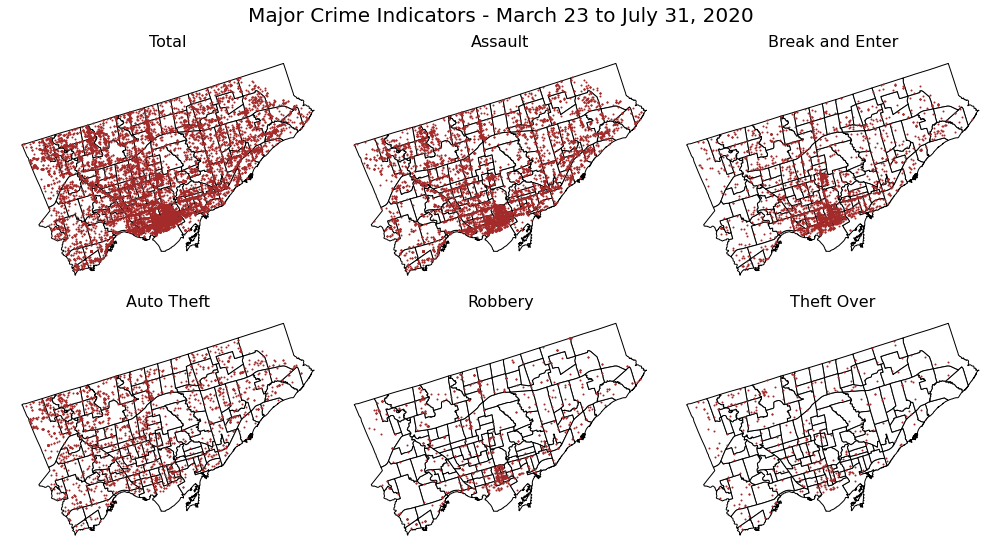

In [9]:
# combined maps - crime points by type

f = plt.figure()
f.set_size_inches(14, 8)
f.suptitle(f"Major Crime Indicators - March 23 to July 31, 2020", ha='center', size=20)

ax1 = plt.subplot(2, 3, 1)
base = nbs.plot(figsize=(6,4), color='white', edgecolor='black', ax=ax1)
LD1.loc[(LD1['MCI']=='Assault')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
LD1.loc[(LD1['MCI']=='Auto Theft')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
LD1.loc[(LD1['MCI']=='Break and Enter')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
LD1.loc[(LD1['MCI']=='Robbery')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
LD1.loc[(LD1['MCI']=='Theft Over')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
plt.title('Total', fontsize=16, color='black')
plt.axis('off')
 
ax2 = plt.subplot(2, 3, 2)
base = nbs.plot(figsize=(6,4), color='white', edgecolor='black', ax=ax2)
LD1.loc[(LD1['MCI']=='Assault')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
plt.title('Assault', fontsize=16, color='black')
plt.axis('off')

ax3 = plt.subplot(2, 3, 3)
base = nbs.plot(figsize=(6,4), color='white', edgecolor='black', ax=ax3)
LD1.loc[(LD1['MCI']=='Break and Enter')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
plt.title('Break and Enter', fontsize=16, color='black')
plt.axis('off')

ax4 = plt.subplot(2, 3, 4)
base = nbs.plot(figsize=(6,4), color='white', edgecolor='black', ax=ax4)
LD1.loc[(LD1['MCI']=='Auto Theft')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
plt.title('Auto Theft', fontsize=16, color='black')
plt.axis('off')

ax5 = plt.subplot(2, 3, 5)
base = nbs.plot(figsize=(6,4), color='white', edgecolor='black', ax=ax5)
LD1.loc[(LD1['MCI']=='Robbery')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
plt.title('Robbery', fontsize=16, color='black')
plt.axis('off')

ax6 = plt.subplot(2, 3, 6)
base = nbs.plot(figsize=(6,4), color='white', edgecolor='black', ax=ax6)
LD1.loc[(LD1['MCI']=='Theft Over')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
plt.title('Theft Over', fontsize=16, color='black')
plt.axis('off')

f.tight_layout()

path = os.path.join('','img')
fn = 'LD-MCIs.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

#### One Year Previous - March 23 to July 31, 2019

In [10]:
# now let's do the same for a subset of the 2019 non-lockdown period (OYP) 

# get subset
OYP = (crime['TimeSeries'] > '2019-03-23') & (crime['TimeSeries'] < '2019-07-31')
OYP = crime.loc[OYP]

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later


Done.


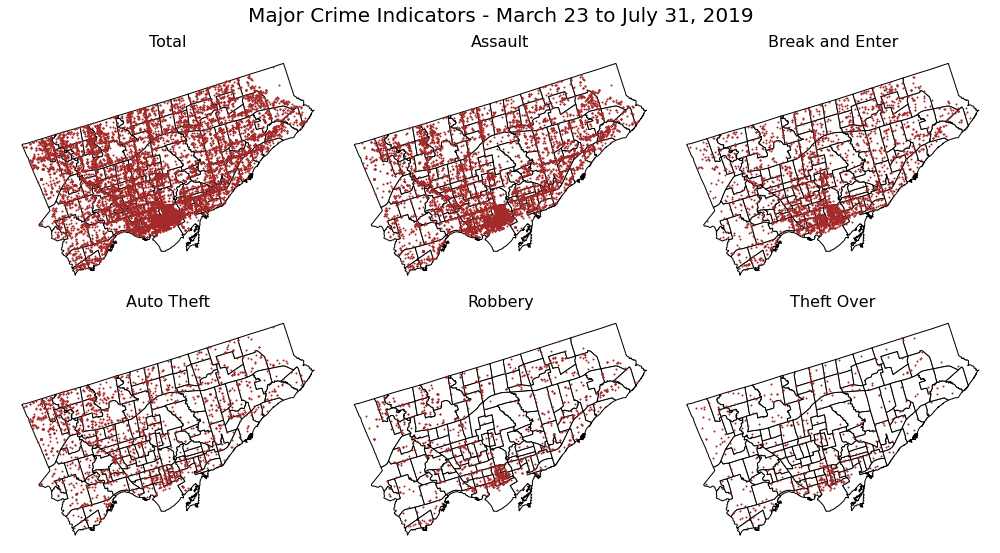

In [11]:
# combined maps - crime points by type

f = plt.figure()
f.set_size_inches(14, 8)
f.suptitle(f"Major Crime Indicators - March 23 to July 31, 2019", ha='center', size=20)

ax1 = plt.subplot(2, 3, 1)
base = nbs.plot(figsize=(6,4), color='white', edgecolor='black', ax=ax1)
OYP.loc[(OYP['MCI']=='Assault')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
OYP.loc[(OYP['MCI']=='Auto Theft')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
OYP.loc[(OYP['MCI']=='Break and Enter')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
OYP.loc[(OYP['MCI']=='Robbery')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
OYP.loc[(OYP['MCI']=='Theft Over')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
plt.title('Total', fontsize=16, color='black')
plt.axis('off')
 
ax2 = plt.subplot(2, 3, 2)
base = nbs.plot(figsize=(6,4), color='white', edgecolor='black', ax=ax2)
OYP.loc[(OYP['MCI']=='Assault')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
plt.title('Assault', fontsize=16, color='black')
plt.axis('off')

ax3 = plt.subplot(2, 3, 3)
base = nbs.plot(figsize=(6,4), color='white', edgecolor='black', ax=ax3)
OYP.loc[(OYP['MCI']=='Break and Enter')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
plt.title('Break and Enter', fontsize=16, color='black')
plt.axis('off')

ax4 = plt.subplot(2, 3, 4)
base = nbs.plot(figsize=(6,4), color='white', edgecolor='black', ax=ax4)
OYP.loc[(OYP['MCI']=='Auto Theft')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
plt.title('Auto Theft', fontsize=16, color='black')
plt.axis('off')

ax5 = plt.subplot(2, 3, 5)
base = nbs.plot(figsize=(6,4), color='white', edgecolor='black', ax=ax5)
OYP.loc[(OYP['MCI']=='Robbery')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
plt.title('Robbery', fontsize=16, color='black')
plt.axis('off')

ax6 = plt.subplot(2, 3, 6)
base = nbs.plot(figsize=(6,4), color='white', edgecolor='black', ax=ax6)
OYP.loc[(OYP['MCI']=='Theft Over')].plot(figsize=(6,4), marker='o', color='brown', markersize=1, ax=base)
plt.title('Theft Over', fontsize=16, color='black')
plt.axis('off')

f.tight_layout()

path = os.path.join('','img')
fn = 'OYP-MCIs.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

## 1.2. Calculate Crime Rates

#### First Lockdown - March 23 to July 31, 2020

In [12]:
# get crime counts per neighbourhood by crime type
LD1 = LD1.groupby(["Hood_ID", "MCI"], as_index=False)["ObjectId"].count()

# change name of ObjectID to Total Crime
LD1.rename(columns={'ObjectId': 'Total'}, inplace=True)

# confirm
LD1

,Hood_ID,MCI,Total
0,1,Assault,78
1,1,Auto Theft,139
2,1,Break and Enter,29
3,1,Robbery,22
4,1,Theft Over,21
...,...,...,...
645,139,Theft Over,1
646,140,Assault,14
647,140,Auto Theft,4
648,140,Break and Enter,1


In [13]:
# split each crime type into its own column
LD1Split = LD1.pivot_table(values='Total', index=LD1.index, columns='MCI', aggfunc='first')

# and add them back into dataframe
LD1 = LD1.join(LD1Split, lsuffix="_left")

# rename the columns
LD1.rename(columns={'Auto Theft':'AutoTheft', 'Break and Enter':'BreakEnter', 'Theft Over':'TheftOver'}, inplace=True)

# confirm
LD1

,Hood_ID,MCI,Total,Assault,AutoTheft,BreakEnter,Robbery,TheftOver
0,1,Assault,78,78.0,NaN,NaN,NaN,NaN
1,1,Auto Theft,139,NaN,139.0,NaN,NaN,NaN
2,1,Break and Enter,29,NaN,NaN,29.0,NaN,NaN
3,1,Robbery,22,NaN,NaN,NaN,22.0,NaN
4,1,Theft Over,21,NaN,NaN,NaN,NaN,21.0
...,...,...,...,...,...,...,...,...
645,139,Theft Over,1,NaN,NaN,NaN,NaN,1.0
646,140,Assault,14,14.0,NaN,NaN,NaN,NaN
647,140,Auto Theft,4,NaN,4.0,NaN,NaN,NaN
648,140,Break and Enter,1,NaN,NaN,1.0,NaN,NaN


In [14]:
# merge data into one row per neighbourhood
LD1 = LD1.groupby("Hood_ID").sum()

# confirm LD1
LD1

,Total,Assault,AutoTheft,BreakEnter,Robbery,TheftOver
Hood_ID,,,,,,
1,289,78.0,139.0,29.0,22.0,21.0
2,100,45.0,38.0,5.0,8.0,4.0
3,50,19.0,19.0,7.0,3.0,2.0
4,41,17.0,19.0,5.0,0.0,0.0
5,32,12.0,15.0,5.0,0.0,0.0
...,...,...,...,...,...,...
136,171,117.0,21.0,23.0,10.0,0.0
137,151,101.0,18.0,20.0,8.0,4.0
138,74,51.0,8.0,6.0,6.0,3.0


In [15]:
# add neighoburhood data
LD1 = pd.merge(LD1, nbs, on=['Hood_ID'])
LD1 = GeoDataFrame(LD1)

# delete columns
cols2drop1 = ['_id']
for col in LD1.columns:
    if col in cols2drop1:
        LD1.drop(col, inplace=True, axis=1)

# reorder columns
LD1 = LD1[['Hood_ID', 'Neighbourhood', 'Pop', 'Total', 'Assault', 'AutoTheft', 'BreakEnter', 'Robbery', 'TheftOver', 'geometry']]

# confirm LD1
LD1

,Hood_ID,Neighbourhood,Pop,Total,Assault,AutoTheft,BreakEnter,Robbery,TheftOver,geometry
0,1,West Humber-Clairville,33312,289,78.0,139.0,29.0,22.0,21.0,"POLYGON ((-79.55236 43.70947, -79.55238 43.709..."
1,2,Mount Olive-Silverstone-Jamestown,32954,100,45.0,38.0,5.0,8.0,4.0,"POLYGON ((-79.60338 43.75786, -79.60205 43.758..."
2,3,Thistletown-Beaumond Heights,10360,50,19.0,19.0,7.0,3.0,2.0,"POLYGON ((-79.57751 43.73384, -79.57806 43.734..."
3,4,Rexdale-Kipling,10529,41,17.0,19.0,5.0,0.0,0.0,"POLYGON ((-79.55512 43.71510, -79.55504 43.714..."
4,5,Elms-Old Rexdale,9456,32,12.0,15.0,5.0,0.0,0.0,"POLYGON ((-79.55512 43.71510, -79.55569 43.716..."
...,...,...,...,...,...,...,...,...,...,...
135,136,West Hill,27392,171,117.0,21.0,23.0,10.0,0.0,"POLYGON ((-79.20206 43.76487, -79.20215 43.764..."
136,137,Woburn,53485,151,101.0,18.0,20.0,8.0,4.0,"POLYGON ((-79.21128 43.75113, -79.21135 43.751..."
137,138,Eglinton East,22776,74,51.0,8.0,6.0,6.0,3.0,"POLYGON ((-79.24549 43.73060, -79.24602 43.731..."
138,139,Scarborough Village,16724,90,71.0,6.0,6.0,6.0,1.0,"POLYGON ((-79.21397 43.72676, -79.21400 43.726..."


In [16]:
# add crime rate columns using [(crime count / Pop)*100,000] for each crime type
LD1['TotalRate'] = ((LD1['Total']/LD1['Pop'])*100000).round(decimals = 2)
LD1['AssaultRate'] = ((LD1['Assault']/LD1['Pop'])*100000).round(decimals = 2)
LD1['AutoTheftRate'] = ((LD1['AutoTheft']/LD1['Pop'])*100000).round(decimals = 2)
LD1['BreakEnterRate'] = ((LD1['BreakEnter']/LD1['Pop'])*100000).round(decimals = 2)
LD1['RobberyRate'] = ((LD1['Robbery']/LD1['Pop'])*100000).round(decimals = 2)
LD1['TheftOverRate'] = ((LD1['TheftOver']/LD1['Pop'])*100000).round(decimals = 2)

# confirm
LD1.head()

,Hood_ID,Neighbourhood,Pop,Total,Assault,AutoTheft,BreakEnter,Robbery,TheftOver,geometry,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
0,1,West Humber-Clairville,33312,289,78.0,139.0,29.0,22.0,21.0,"POLYGON ((-79.55236 43.70947, -79.55238 43.709...",867.56,234.15,417.27,87.06,66.04,63.04
1,2,Mount Olive-Silverstone-Jamestown,32954,100,45.0,38.0,5.0,8.0,4.0,"POLYGON ((-79.60338 43.75786, -79.60205 43.758...",303.45,136.55,115.31,15.17,24.28,12.14
2,3,Thistletown-Beaumond Heights,10360,50,19.0,19.0,7.0,3.0,2.0,"POLYGON ((-79.57751 43.73384, -79.57806 43.734...",482.63,183.40,183.40,67.57,28.96,19.31
3,4,Rexdale-Kipling,10529,41,17.0,19.0,5.0,0.0,0.0,"POLYGON ((-79.55512 43.71510, -79.55504 43.714...",389.40,161.46,180.45,47.49,0.00,0.00
4,5,Elms-Old Rexdale,9456,32,12.0,15.0,5.0,0.0,0.0,"POLYGON ((-79.55512 43.71510, -79.55569 43.716...",338.41,126.90,158.63,52.88,0.00,0.00


In [17]:
# peek at final data
LD1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 140 entries, 0 to 139
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Hood_ID         140 non-null    int64   
 1   Neighbourhood   140 non-null    object  
 2   Pop             140 non-null    int64   
 3   Total           140 non-null    int64   
 4   Assault         140 non-null    float64 
 5   AutoTheft       140 non-null    float64 
 6   BreakEnter      140 non-null    float64 
 7   Robbery         140 non-null    float64 
 8   TheftOver       140 non-null    float64 
 9   geometry        140 non-null    geometry
 10  TotalRate       140 non-null    float64 
 11  AssaultRate     140 non-null    float64 
 12  AutoTheftRate   140 non-null    float64 
 13  BreakEnterRate  140 non-null    float64 
 14  RobberyRate     140 non-null    float64 
 15  TheftOverRate   140 non-null    float64 
dtypes: float64(11), geometry(1), int64(3), object(1)
memor

#### One Year Previous - March 23 to July 31, 2019

In [18]:
# now let's do the same for a subset of the 2019 non-lockdown period (OYP) 

# get crime counts per neighbourhood by crime type
OYP = OYP.groupby(["Hood_ID", "MCI"], as_index=False)["ObjectId"].count()

# split each crime type into its own column and add them back into dataframe
OYPSplit = OYP.pivot_table(values='ObjectId', index=OYP.index, columns='MCI', aggfunc='first')
OYP = OYP.join(OYPSplit, lsuffix="_left")

# merge data into one row per neighbourhood
OYP = OYP.groupby("Hood_ID").sum()

# add neighoburhood data
OYP = pd.merge(OYP, nbs, on=['Hood_ID'])
OYP = GeoDataFrame(OYP)

# delete columns
cols2drop1 = ['_id']
for col in OYP.columns:
    if col in cols2drop1:
        OYP.drop(col, inplace=True, axis=1)

# rename columns
OYP.rename(columns={'ObjectId': 'Total', 'Auto Theft':'AutoTheft', 'Break and Enter':'BreakEnter', 'Theft Over':'TheftOver'}, inplace=True)

# reorder columns
OYP = OYP[['Hood_ID', 'Neighbourhood', 'Pop', 'Total', 'Assault', 'AutoTheft', 'BreakEnter', 'Robbery', 'TheftOver', 'geometry']]

# add crime rate columns using [(crime count / Pop)*100,000] for each crime type
OYP['TotalRate'] = ((OYP['Total']/OYP['Pop'])*100000).round(decimals = 2)
OYP['AssaultRate'] = ((OYP['Assault']/OYP['Pop'])*100000).round(decimals = 2)
OYP['AutoTheftRate'] = ((OYP['AutoTheft']/OYP['Pop'])*100000).round(decimals = 2)
OYP['BreakEnterRate'] = ((OYP['BreakEnter']/OYP['Pop'])*100000).round(decimals = 2)
OYP['RobberyRate'] = ((OYP['Robbery']/OYP['Pop'])*100000).round(decimals = 2)
OYP['TheftOverRate'] = ((OYP['TheftOver']/OYP['Pop'])*100000).round(decimals = 2)

# confirm
OYP.head()

,Hood_ID,Neighbourhood,Pop,Total,Assault,AutoTheft,BreakEnter,Robbery,TheftOver,geometry,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
0,1,West Humber-Clairville,33312,355,101.0,168.0,46.0,17.0,23.0,"POLYGON ((-79.55236 43.70947, -79.55238 43.709...",1065.68,303.19,504.32,138.09,51.03,69.04
1,2,Mount Olive-Silverstone-Jamestown,32954,163,94.0,35.0,7.0,22.0,5.0,"POLYGON ((-79.60338 43.75786, -79.60205 43.758...",494.63,285.25,106.21,21.24,66.76,15.17
2,3,Thistletown-Beaumond Heights,10360,65,29.0,20.0,11.0,3.0,2.0,"POLYGON ((-79.57751 43.73384, -79.57806 43.734...",627.41,279.92,193.05,106.18,28.96,19.31
3,4,Rexdale-Kipling,10529,51,21.0,17.0,7.0,6.0,0.0,"POLYGON ((-79.55512 43.71510, -79.55504 43.714...",484.38,199.45,161.46,66.48,56.99,0.00
4,5,Elms-Old Rexdale,9456,39,17.0,10.0,3.0,7.0,2.0,"POLYGON ((-79.55512 43.71510, -79.55569 43.716...",412.44,179.78,105.75,31.73,74.03,21.15


In [19]:
# peek at final data
OYP.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 140 entries, 0 to 139
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Hood_ID         140 non-null    int64   
 1   Neighbourhood   140 non-null    object  
 2   Pop             140 non-null    int64   
 3   Total           140 non-null    int64   
 4   Assault         140 non-null    float64 
 5   AutoTheft       140 non-null    float64 
 6   BreakEnter      140 non-null    float64 
 7   Robbery         140 non-null    float64 
 8   TheftOver       140 non-null    float64 
 9   geometry        140 non-null    geometry
 10  TotalRate       140 non-null    float64 
 11  AssaultRate     140 non-null    float64 
 12  AutoTheftRate   140 non-null    float64 
 13  BreakEnterRate  140 non-null    float64 
 14  RobberyRate     140 non-null    float64 
 15  TheftOverRate   140 non-null    float64 
dtypes: float64(11), geometry(1), int64(3), object(1)
memor

## 1.3. Explore Crime Data

#### First Lockdown - March 23 to July 31, 2020

In [20]:
# summarize LD1 data
LD1.describe().round(decimals = 2)

,Hood_ID,Pop,Total,Assault,AutoTheft,BreakEnter,Robbery,TheftOver,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
count,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00
mean,70.50,19511.22,82.44,43.61,14.16,16.55,5.46,2.66,411.18,214.90,72.23,84.53,26.40,13.12
std,40.56,10033.59,77.16,45.76,15.48,20.59,7.16,3.50,268.41,166.96,61.75,81.71,29.23,13.73
min,1.00,6577.00,10.00,4.00,0.00,0.00,0.00,0.00,117.64,29.71,0.00,0.00,0.00,0.00
25%,35.75,12019.50,39.75,17.00,5.75,6.00,1.75,1.00,249.62,124.68,35.28,35.98,9.08,4.28
50%,70.50,16749.50,61.50,31.50,10.00,10.00,3.50,2.00,357.46,178.90,56.15,63.81,20.96,9.54
75%,105.25,23854.50,90.00,51.00,18.00,17.00,7.00,3.00,465.31,249.16,88.56,101.87,35.27,19.04
max,140.00,65913.00,473.00,284.00,139.00,131.00,50.00,21.00,2189.60,1384.96,442.98,462.52,243.83,96.65


/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later


Done.


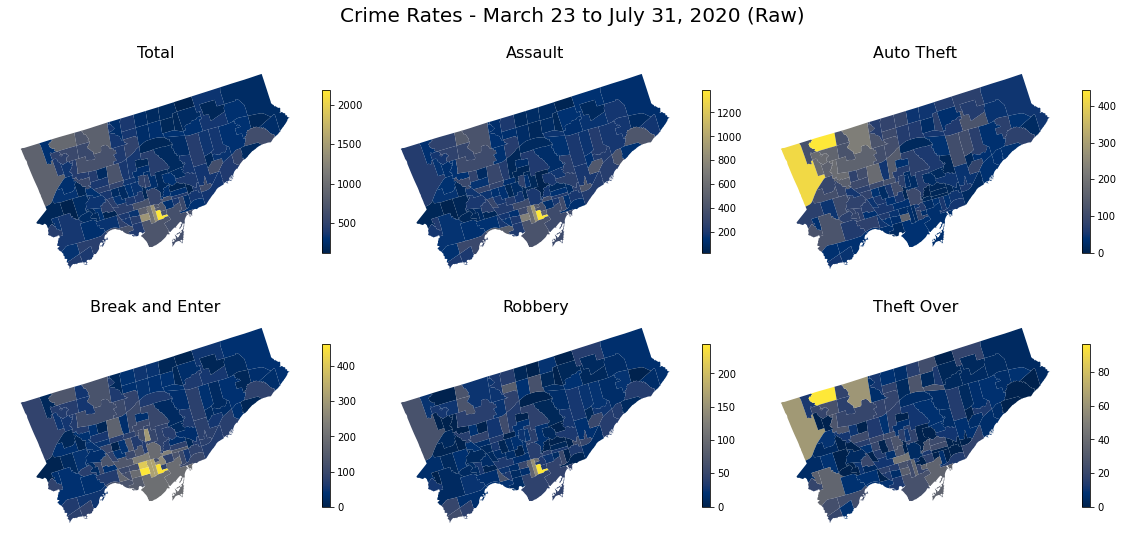

In [21]:
# combined maps - raw chloropleth

f = plt.figure()
f.set_size_inches(16, 8)
f.suptitle(f"Crime Rates - March 23 to July 31, 2020 (Raw)", ha='center', size=20)

ax1 = plt.subplot(2, 3, 1)
plt.title('Total', fontsize=16, color='black')
plt.axis('off')
LD1.plot(column='TotalRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax1)
 
ax2 = plt.subplot(2, 3, 2)
plt.title('Assault', fontsize=16, color='black')
plt.axis('off')
LD1.plot(column='AssaultRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax2)

ax3 = plt.subplot(2, 3, 3)
plt.title('Auto Theft', fontsize=16, color='black')
plt.axis('off')
LD1.plot(column='AutoTheftRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax3)

ax4 = plt.subplot(2, 3, 4)
plt.title('Break and Enter', fontsize=16, color='black')
plt.axis('off')
LD1.plot(column='BreakEnterRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax4)

ax5 = plt.subplot(2, 3, 5)
plt.title('Robbery', fontsize=16, color='black')
plt.axis('off')
LD1.plot(column='RobberyRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax5)

ax6 = plt.subplot(2, 3, 6)
plt.title('Theft Over', fontsize=16, color='black')
plt.axis('off')
LD1.plot(column='TheftOverRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax6)

f.tight_layout()

path = os.path.join('','img')
fn = 'LD-crime-rates-cluster-raw.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

In [22]:
# what neighboruhoods have the highest crime rates during lockdown?
LD1a = LD1.loc[LD1.TotalRate == LD1.TotalRate.max(), 'Neighbourhood'].values[0]
LD1b = LD1.loc[LD1.AssaultRate == LD1.AssaultRate.max(), 'Neighbourhood'].values[0]
LD1c = LD1.loc[LD1.AutoTheftRate == LD1.AutoTheftRate.max(), 'Neighbourhood'].values[0]
LD1d = LD1.loc[LD1.BreakEnterRate == LD1.BreakEnterRate.max(), 'Neighbourhood'].values[0]
LD1e = LD1.loc[LD1.RobberyRate == LD1.RobberyRate.max(), 'Neighbourhood'].values[0]
LD1f = LD1.loc[LD1.TheftOverRate == LD1.TheftOverRate.max(), 'Neighbourhood'].values[0]

print(f"During the first lockdown:")
print(f"{LD1a} had the highest overall crime rate.")
print(f"{LD1b} had the highest assault rate.")
print(f"{LD1c} had the highest auto theft rate.")
print(f"{LD1d} had the highest break enter rate.")
print(f"{LD1e} had the highest robbery rate.")
print(f"{LD1f} had the highest theftover rate.")
print(f"These will be key neighbourhoods for cluster interpretation.")

During the first lockdown:
Moss Park had the highest overall crime rate.
Moss Park had the highest assault rate.
Humber Summit had the highest auto theft rate.
Kensington-Chinatown had the highest break enter rate.
Moss Park had the highest robbery rate.
Humber Summit had the highest theftover rate.
These will be key neighbourhoods for cluster interpretation.


In [23]:
# what was the average crime rate of each MCI?
LD1g = LD1.TotalRate.mean().round(decimals = 2)
LD1h = LD1.AssaultRate.mean().round(decimals = 2)
LD1i = LD1.AutoTheftRate.mean().round(decimals = 2)
LD1j = LD1.BreakEnterRate.mean().round(decimals = 2)
LD1k = LD1.RobberyRate.mean().round(decimals = 2)
LD1l = LD1.TheftOverRate.mean().round(decimals = 2)

print(f"During the first lockdown:")
print(f"The average crime rate was {LD1g}.")
print(f"The average assault rate was {LD1h}.")
print(f"The average auto theft rate was {LD1i}.")
print(f"The average break enter rate was {LD1j}.")
print(f"The average robbery rate was {LD1k}.")
print(f"The average theft over rate was {LD1l}.")
print(f"These will be key statistics for cluster interpretation.")

During the first lockdown:
The average crime rate was 411.18.
The average assault rate was 214.9.
The average auto theft rate was 72.23.
The average break enter rate was 84.53.
The average robbery rate was 26.4.
The average theft over rate was 13.12.
These will be key statistics for cluster interpretation.


#### One Year Previous - March 23 to July 31, 2019

In [24]:
# summarize data
OYP.describe().round(decimals = 2)

,Hood_ID,Pop,Total,Assault,AutoTheft,BreakEnter,Robbery,TheftOver,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
count,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00,140.00
mean,70.50,19511.22,102.71,55.43,13.21,22.12,8.36,3.58,513.72,272.83,68.41,111.67,43.09,17.71
std,40.56,10033.59,94.37,58.47,17.01,22.32,9.39,4.39,319.62,200.82,67.82,89.50,42.14,16.70
min,1.00,6577.00,16.00,6.00,0.00,1.00,0.00,0.00,180.03,66.33,0.00,10.83,0.00,0.00
25%,35.75,12019.50,50.00,24.00,5.00,10.00,3.00,1.00,324.19,144.05,29.58,60.82,18.84,7.98
50%,70.50,16749.50,71.00,37.00,9.00,16.00,6.00,2.00,433.28,231.70,52.34,94.82,33.52,14.39
75%,105.25,23854.50,117.00,65.00,16.00,26.25,10.00,4.00,580.44,323.06,81.27,128.28,52.39,22.48
max,140.00,65913.00,564.00,354.00,168.00,137.00,70.00,28.00,2170.10,1372.25,504.32,691.00,341.36,108.54


/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later


Done.


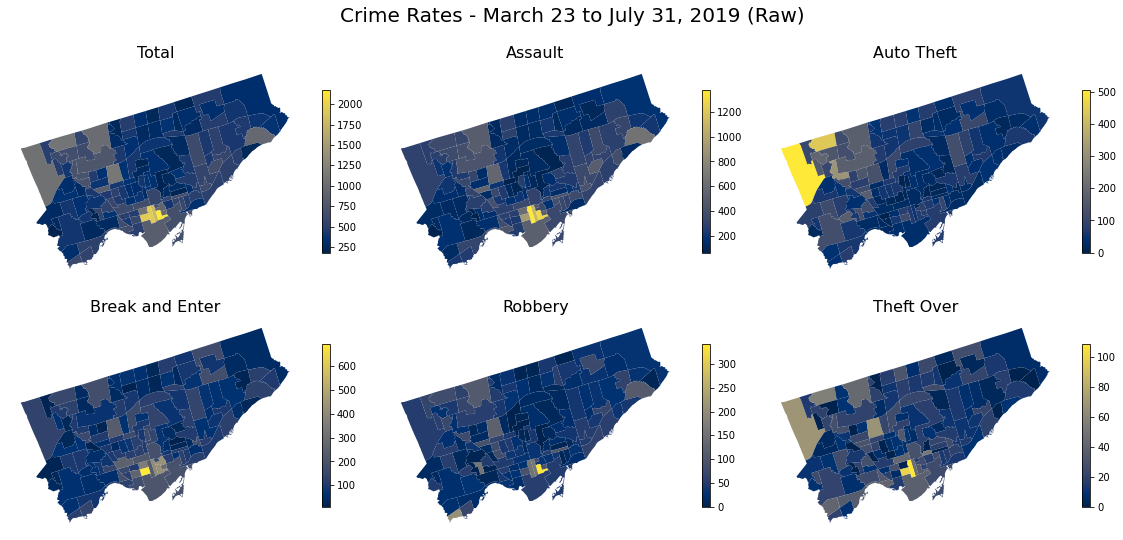

In [25]:
# combined maps - raw chloropleth

f = plt.figure()
f.set_size_inches(16, 8)
f.suptitle(f"Crime Rates - March 23 to July 31, 2019 (Raw)", ha='center', size=20)

ax1 = plt.subplot(2, 3, 1)
plt.title('Total', fontsize=16, color='black')
plt.axis('off')
OYP.plot(column='TotalRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax1)
 
ax2 = plt.subplot(2, 3, 2)
plt.title('Assault', fontsize=16, color='black')
plt.axis('off')
OYP.plot(column='AssaultRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax2)

ax3 = plt.subplot(2, 3, 3)
plt.title('Auto Theft', fontsize=16, color='black')
plt.axis('off')
OYP.plot(column='AutoTheftRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax3)

ax4 = plt.subplot(2, 3, 4)
plt.title('Break and Enter', fontsize=16, color='black')
plt.axis('off')
OYP.plot(column='BreakEnterRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax4)

ax5 = plt.subplot(2, 3, 5)
plt.title('Robbery', fontsize=16, color='black')
plt.axis('off')
OYP.plot(column='RobberyRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax5)

ax6 = plt.subplot(2, 3, 6)
plt.title('Theft Over', fontsize=16, color='black')
plt.axis('off')
OYP.plot(column='TheftOverRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax6)

f.tight_layout()

path = os.path.join('','img')
fn = 'OYP-crime-rates-cluster-raw.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

In [26]:
# what neighbourhoods have the highest crime rates?
OYPa = OYP.loc[OYP.TotalRate == OYP.TotalRate.max(), 'Neighbourhood'].values[0]
OYPb = OYP.loc[OYP.AssaultRate == OYP.AssaultRate.max(), 'Neighbourhood'].values[0]
OYPc = OYP.loc[OYP.AutoTheftRate == OYP.AutoTheftRate.max(), 'Neighbourhood'].values[0]
OYPd = OYP.loc[OYP.BreakEnterRate == OYP.BreakEnterRate.max(), 'Neighbourhood'].values[0]
OYPe = OYP.loc[OYP.RobberyRate == OYP.RobberyRate.max(), 'Neighbourhood'].values[0]
OYPf = OYP.loc[OYP.TheftOverRate == OYP.TheftOverRate.max(), 'Neighbourhood'].values[0]

print(f"During the same time period a year before the first lockdown:")
print(f"{OYPa} had the highest overall crime rate.")
print(f"{OYPb} had the highest assault rate.")
print(f"{OYPc} had the highest auto theft rate.")
print(f"{OYPd} had the highest break enter rate.")
print(f"{OYPe} had the highest robbery rate.")
print(f"{OYPf} had the highest theftover rate.")
print(f"These will be key neighbourhoods for cluster interpretation.")

During the same time period a year before the first lockdown:
Moss Park had the highest overall crime rate.
Bay Street Corridor had the highest assault rate.
West Humber-Clairville had the highest auto theft rate.
Kensington-Chinatown had the highest break enter rate.
Moss Park had the highest robbery rate.
Bay Street Corridor had the highest theftover rate.
These will be key neighbourhoods for cluster interpretation.


In [27]:
# what was the average crime rate of each MCI?
OYPg = OYP.TotalRate.mean().round(decimals = 2)
OYPh = OYP.AssaultRate.mean().round(decimals = 2)
OYPi = OYP.AutoTheftRate.mean().round(decimals = 2)
OYPj = OYP.BreakEnterRate.mean().round(decimals = 2)
OYPk = OYP.RobberyRate.mean().round(decimals = 2)
OYPl = OYP.TheftOverRate.mean().round(decimals = 2)

print(f"During the same time period a year before the first lockdown:")
print(f"The average crime rate was {OYPg}.")
print(f"The average assault rate was {OYPh}.")
print(f"The average auto theft rate was {OYPi}.")
print(f"The average break enter rate was {OYPj}.")
print(f"The average robbery rate was {OYPk}.")
print(f"The average theft over rate was {OYPl}.")
print(f"These will be key statistics for cluster interpretation.")

During the same time period a year before the first lockdown:
The average crime rate was 513.72.
The average assault rate was 272.83.
The average auto theft rate was 68.41.
The average break enter rate was 111.67.
The average robbery rate was 43.09.
The average theft over rate was 17.71.
These will be key statistics for cluster interpretation.


In [28]:
# what was the difference in average crime rates of each MCI during the lockdown compared to the same time period a year before
totaldiff = (LD1g - OYPg).round(decimals = 2)
assaultdiff = (LD1h - OYPh).round(decimals = 2)
autotheftdiff = (LD1i - OYPi).round(decimals = 2)
breakenterdiff = (LD1j - OYPj).round(decimals = 2)
robberydiff = (LD1k - OYPk).round(decimals = 2)
theftoverdiff = (LD1l - OYPl).round(decimals = 2)

print(f"The crime rate changed by {totaldiff} during the lockdown.")
print(f"The assault rate changed by {assaultdiff} during the lockdown.")
print(f"The auto theft rate changed by {autotheftdiff} during the lockdown.")
print(f"The break enter rate changed by {breakenterdiff} during the lockdown.")
print(f"The robbery rate changed by {robberydiff} during the lockdown.")
print(f"The theft over rate changed by {theftoverdiff} during the lockdown.")
print(f"These will be key statistics for cluster interpretation.")

The crime rate changed by -102.54 during the lockdown.
The assault rate changed by -57.93 during the lockdown.
The auto theft rate changed by 3.82 during the lockdown.
The break enter rate changed by -27.14 during the lockdown.
The robbery rate changed by -16.69 during the lockdown.
The theft over rate changed by -4.59 during the lockdown.
These will be key statistics for cluster interpretation.


#### Preliminary observations

- Moss Park, Humber Summit, West Humber-Clairville, Kensington-Chinatown, and Bay Street Corridor will be important neighbourhoods within our clusters
- the lockdown appears to have shifted the concentration of assaults, auto theft, and theft over the most
- the lockdown resulted in a universal decrease in all crime rates, except auto theft, which actually increased
- both one year previous and during the lockdown, crime seems to be concentrated within the city's downtown and northwest corner

## 1.4. Normalize

#### First Lockdown - March 23 to July 31, 2020

In [29]:
rs = RobustScaler(quantile_range=(10.0, 90.0))

In [30]:
LD1.head()

,Hood_ID,Neighbourhood,Pop,Total,Assault,AutoTheft,BreakEnter,Robbery,TheftOver,geometry,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
0,1,West Humber-Clairville,33312,289,78.0,139.0,29.0,22.0,21.0,"POLYGON ((-79.55236 43.70947, -79.55238 43.709...",867.56,234.15,417.27,87.06,66.04,63.04
1,2,Mount Olive-Silverstone-Jamestown,32954,100,45.0,38.0,5.0,8.0,4.0,"POLYGON ((-79.60338 43.75786, -79.60205 43.758...",303.45,136.55,115.31,15.17,24.28,12.14
2,3,Thistletown-Beaumond Heights,10360,50,19.0,19.0,7.0,3.0,2.0,"POLYGON ((-79.57751 43.73384, -79.57806 43.734...",482.63,183.40,183.40,67.57,28.96,19.31
3,4,Rexdale-Kipling,10529,41,17.0,19.0,5.0,0.0,0.0,"POLYGON ((-79.55512 43.71510, -79.55504 43.714...",389.40,161.46,180.45,47.49,0.00,0.00
4,5,Elms-Old Rexdale,9456,32,12.0,15.0,5.0,0.0,0.0,"POLYGON ((-79.55512 43.71510, -79.55569 43.716...",338.41,126.90,158.63,52.88,0.00,0.00


In [31]:
raw = LD1[['Hood_ID', 'TotalRate', 'AssaultRate','AutoTheftRate', 'BreakEnterRate', 'RobberyRate', 'TheftOverRate']].set_index('Hood_ID').copy()
raw.head()

,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
Hood_ID,,,,,,
1,867.56,234.15,417.27,87.06,66.04,63.04
2,303.45,136.55,115.31,15.17,24.28,12.14
3,482.63,183.40,183.40,67.57,28.96,19.31
4,389.40,161.46,180.45,47.49,0.00,0.00
5,338.41,126.90,158.63,52.88,0.00,0.00


In [32]:
LD1normed = raw.copy()
for c in raw.columns.values:
    LD1normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, LD1normed[c].min(), LD1normed[c].max()))
LD1normed.head()

The range of TotalRate is [-0.4736441916498795, 3.6183888296401614]
The range of AssaultRate is [-0.4650996040776879, 3.7598902640521232]
The range of AutoTheftRate is [-0.5419517986236451, 3.7336280367156665]
The range of BreakEnterRate is [-0.4192454764063545, 2.619610780410243]
The range of RobberyRate is [-0.3965311796637096, 4.215259783246013]
The range of TheftOverRate is [-0.36141839672677667, 3.300121230489468]


,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
Hood_ID,,,,,,
1,1.007416,0.172242,3.485479,0.152758,0.852547,2.026822
2,-0.106677,-0.132026,0.571004,-0.319575,0.062700,0.098500
3,0.247196,0.014029,1.228199,0.024704,0.151217,0.370132
4,0.063070,-0.054369,1.199726,-0.107226,-0.396531,-0.361418
5,-0.037633,-0.162110,0.989122,-0.071812,-0.396531,-0.361418


In [33]:
# plot normed data
LD1normplot = LD1normed.reset_index()
LD1normplot = pd.merge(LD1normplot, nbs, on=['Hood_ID'])
LD1normplot = GeoDataFrame(LD1normplot)
LD1normplot.head()

,Hood_ID,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate,_id,Neighbourhood,Pop,geometry
0,1,1.007416,0.172242,3.485479,0.152758,0.852547,2.026822,42,West Humber-Clairville,33312,"POLYGON ((-79.55236 43.70947, -79.55238 43.709..."
1,2,-0.106677,-0.132026,0.571004,-0.319575,0.062700,0.098500,103,Mount Olive-Silverstone-Jamestown,32954,"POLYGON ((-79.60338 43.75786, -79.60205 43.758..."
2,3,0.247196,0.014029,1.228199,0.024704,0.151217,0.370132,15,Thistletown-Beaumond Heights,10360,"POLYGON ((-79.57751 43.73384, -79.57806 43.734..."
3,4,0.063070,-0.054369,1.199726,-0.107226,-0.396531,-0.361418,118,Rexdale-Kipling,10529,"POLYGON ((-79.55512 43.71510, -79.55504 43.714..."
4,5,-0.037633,-0.162110,0.989122,-0.071812,-0.396531,-0.361418,34,Elms-Old Rexdale,9456,"POLYGON ((-79.55512 43.71510, -79.55569 43.716..."


/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later


Done.


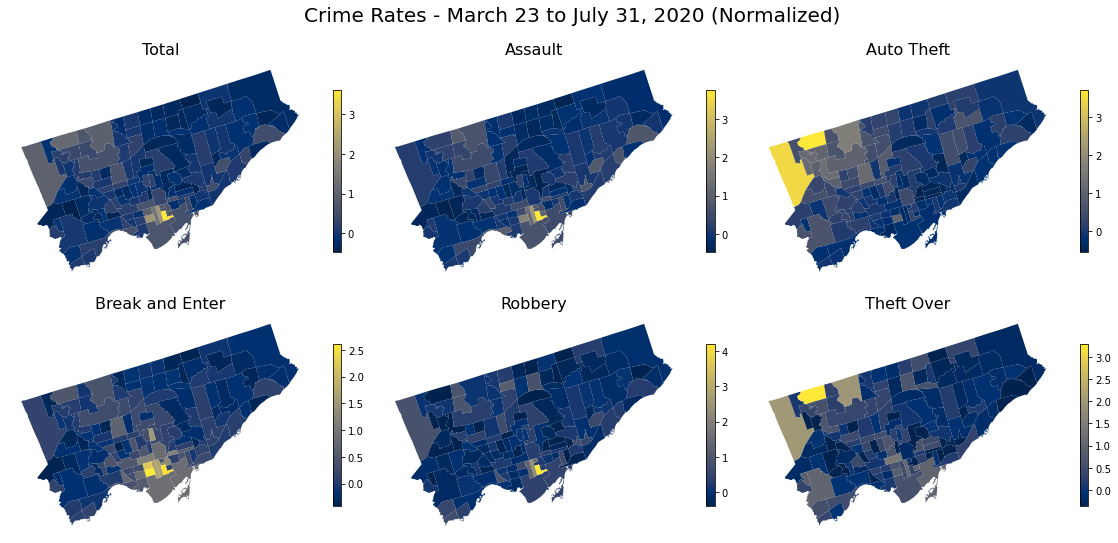

In [34]:
# combined maps - chloropleth normalized

f = plt.figure()
f.set_size_inches(16, 8)
f.suptitle(f"Crime Rates - March 23 to July 31, 2020 (Normalized)", ha='center', size=20)

ax1 = plt.subplot(2, 3, 1)
plt.title('Total', fontsize=16, color='black')
plt.axis('off')
LD1normplot.plot(column='TotalRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax1)
 
ax2 = plt.subplot(2, 3, 2)
plt.title('Assault', fontsize=16, color='black')
plt.axis('off')
LD1normplot.plot(column='AssaultRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax2)

ax3 = plt.subplot(2, 3, 3)
plt.title('Auto Theft', fontsize=16, color='black')
plt.axis('off')
LD1normplot.plot(column='AutoTheftRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax3)

ax4 = plt.subplot(2, 3, 4)
plt.title('Break and Enter', fontsize=16, color='black')
plt.axis('off')
LD1normplot.plot(column='BreakEnterRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax4)

ax5 = plt.subplot(2, 3, 5)
plt.title('Robbery', fontsize=16, color='black')
plt.axis('off')
LD1normplot.plot(column='RobberyRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax5)

ax6 = plt.subplot(2, 3, 6)
plt.title('Theft Over', fontsize=16, color='black')
plt.axis('off')
LD1normplot.plot(column='TheftOverRate', legend=True, legend_kwds={'shrink': 0.6}, cmap='cividis', figsize=(6,4), ax=ax6)

f.tight_layout()

path = os.path.join('','img')
fn = 'LD-crime-rates-cluster-normed.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

In [35]:
# drop TotalRate as it was only needed for mapping and is not needed for clustering
cols2drop2 = ['TotalRate']
for col in LD1normed.columns:
    if col in cols2drop2:
        LD1normed.drop(col, inplace=True, axis=1)

# confirm
LD1normed.head()

,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
Hood_ID,,,,,
1,0.172242,3.485479,0.152758,0.852547,2.026822
2,-0.132026,0.571004,-0.319575,0.062700,0.098500
3,0.014029,1.228199,0.024704,0.151217,0.370132
4,-0.054369,1.199726,-0.107226,-0.396531,-0.361418
5,-0.162110,0.989122,-0.071812,-0.396531,-0.361418


#### One Year Previous - March 23 to July 31, 2019

In [36]:
# let's do the same for one year previous
rs = RobustScaler(quantile_range=(10.0, 90.0))
raw = OYP[['Hood_ID', 'TotalRate', 'AssaultRate','AutoTheftRate', 'BreakEnterRate', 'RobberyRate', 'TheftOverRate']].set_index('Hood_ID').copy()

OYPnormed = raw.copy()
for c in raw.columns.values:
    OYPnormed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, OYPnormed[c].min(), OYPnormed[c].max()))
OYPnormed.head()

The range of TotalRate is [-0.49640809526142904, 3.4043514480325325]
The range of AssaultRate is [-0.5175365298732836, 3.569427883817945]
The range of AutoTheftRate is [-0.4741180200172094, 4.09379104207237]
The range of BreakEnterRate is [-0.5494070629173943, 3.8995506367614436]
The range of RobberyRate is [-0.4638112371990036, 4.260240797121506]
The range of TheftOverRate is [-0.42474689335576604, 2.779007644853744]


,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
Hood_ID,,,,,,
1,1.239565,0.223733,4.093791,0.282994,0.242389,1.613094
2,0.120243,0.167588,0.487886,-0.481316,0.460075,0.023023
3,0.380507,0.150908,1.274444,0.074272,-0.063036,0.145223
4,0.100152,-0.100929,0.988316,-0.185403,0.324869,-0.424747
5,-0.040859,-0.162487,0.483719,-0.412701,0.560684,0.199534


In [37]:
# plot normed data
OYPnormplot = OYPnormed.reset_index()
OYPnormplot = pd.merge(OYPnormplot, nbs, on=['Hood_ID'])
OYPnormplot = GeoDataFrame(OYPnormplot)
OYPnormplot.head()

,Hood_ID,TotalRate,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate,_id,Neighbourhood,Pop,geometry
0,1,1.239565,0.223733,4.093791,0.282994,0.242389,1.613094,42,West Humber-Clairville,33312,"POLYGON ((-79.55236 43.70947, -79.55238 43.709..."
1,2,0.120243,0.167588,0.487886,-0.481316,0.460075,0.023023,103,Mount Olive-Silverstone-Jamestown,32954,"POLYGON ((-79.60338 43.75786, -79.60205 43.758..."
2,3,0.380507,0.150908,1.274444,0.074272,-0.063036,0.145223,15,Thistletown-Beaumond Heights,10360,"POLYGON ((-79.57751 43.73384, -79.57806 43.734..."
3,4,0.100152,-0.100929,0.988316,-0.185403,0.324869,-0.424747,118,Rexdale-Kipling,10529,"POLYGON ((-79.55512 43.71510, -79.55504 43.714..."
4,5,-0.040859,-0.162487,0.483719,-0.412701,0.560684,0.199534,34,Elms-Old Rexdale,9456,"POLYGON ((-79.55512 43.71510, -79.55569 43.716..."


/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later


Done.


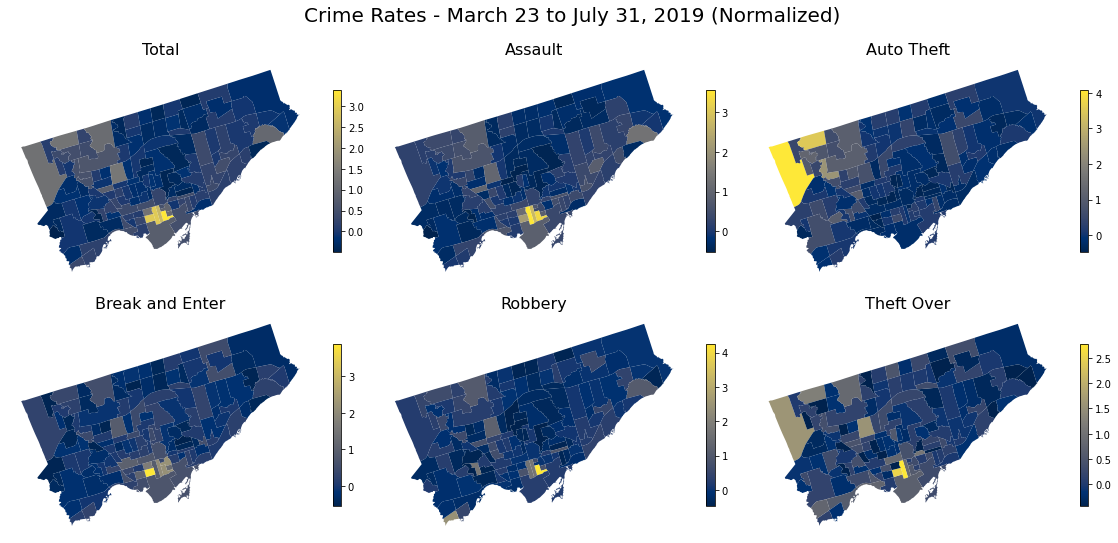

In [38]:
# combined maps - chloropleth normalized

f = plt.figure()
f.set_size_inches(16, 8)
f.suptitle(f"Crime Rates - March 23 to July 31, 2019 (Normalized)", ha='center', size=20)

ax1 = plt.subplot(2, 3, 1)
plt.title('Total', fontsize=16, color='black')
plt.axis('off')
OYPnormplot.plot(column='TotalRate', cmap='cividis', legend=True, legend_kwds={'shrink': 0.6}, figsize=(6,4), ax=ax1)
 
ax2 = plt.subplot(2, 3, 2)
plt.title('Assault', fontsize=16, color='black')
plt.axis('off')
OYPnormplot.plot(column='AssaultRate', cmap='cividis', legend=True, legend_kwds={'shrink': 0.6}, figsize=(6,4), ax=ax2)

ax3 = plt.subplot(2, 3, 3)
plt.title('Auto Theft', fontsize=16, color='black')
plt.axis('off')
OYPnormplot.plot(column='AutoTheftRate', cmap='cividis', legend=True, legend_kwds={'shrink': 0.6}, figsize=(6,4), ax=ax3)

ax4 = plt.subplot(2, 3, 4)
plt.title('Break and Enter', fontsize=16, color='black')
plt.axis('off')
OYPnormplot.plot(column='BreakEnterRate', cmap='cividis', legend=True, legend_kwds={'shrink': 0.6}, figsize=(6,4), ax=ax4)

ax5 = plt.subplot(2, 3, 5)
plt.title('Robbery', fontsize=16, color='black')
plt.axis('off')
OYPnormplot.plot(column='RobberyRate', cmap='cividis', legend=True, legend_kwds={'shrink': 0.6}, figsize=(6,4), ax=ax5)

ax6 = plt.subplot(2, 3, 6)
plt.title('Theft Over', fontsize=16, color='black')
plt.axis('off')
OYPnormplot.plot(column='TheftOverRate', cmap='cividis', legend=True, legend_kwds={'shrink': 0.6}, figsize=(6,4), ax=ax6)

f.tight_layout()

path = os.path.join('','img')
fn = 'OYP-crime-rates-cluster-normed.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

In [39]:
# drop TotalRate as it was only needed for mapping and is not needed for clustering
cols2drop2 = ['TotalRate']
for col in OYPnormed.columns:
    if col in cols2drop2:
        OYPnormed.drop(col, inplace=True, axis=1)

# confirm
OYPnormed.head()

,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
Hood_ID,,,,,
1,0.223733,4.093791,0.282994,0.242389,1.613094
2,0.167588,0.487886,-0.481316,0.460075,0.023023
3,0.150908,1.274444,0.074272,-0.063036,0.145223
4,-0.100929,0.988316,-0.185403,0.324869,-0.424747
5,-0.162487,0.483719,-0.412701,0.560684,0.199534


#### Preliminary observations after normalization

- during the year previous, all crime appeared to be concentrated on downtown except auto theft which was concentrated in the north west
- during the lockdown, assault, robbery, and break and enter remain concentrated downtown, but concentration of break and enter spread out further
- during the lockdown, theft over seems to have changed concentration from downtown to the city's northwest
- auto thefts remain focused on the north west regardless of lockdown or not
- three preliminary clusters are emerging - that of downtown, the north west, and the rest of the city

# 2. Cluster

## 2.1. Functions

In [40]:
# Functions for mapping the clustering results
# Subway layer added for context

# LD1
def LD1mapping_clusters(labels_cluster):
    f = plt.figure()
    f.set_size_inches(8,6)
    ax = subway.plot(color='black', figsize=(12,8), zorder=2)
    plt.title('Kmeans Clustering \n Major Crime Indicators - March 23 to July 31, 2020', fontsize=16, color='black', pad=20)
    plt.axis('off')
    LD1['cluster_nm'] = labels_cluster
    LD1.plot(column='cluster_nm', categorical=True, legend=True, cmap='Paired', ax=ax, zorder=1);
    
# OYP
def OYPmapping_clusters(labels_cluster):
    f = plt.figure()
    f.set_size_inches(8,6)
    ax = subway.plot(color='black', figsize=(12,8), zorder=2)
    plt.title('Kmeans Clustering \n Major Crime Indicators - March 23 to July 31, 2019', fontsize=16, color='black', pad=20)
    plt.axis('off')
    OYP['cluster_nm'] = labels_cluster
    OYP.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8), cmap='Paired', ax=ax, zorder=1);

In [41]:
# Functions for radar plots of the cluster centroids
# taken from practical 5 which was adapted from tutorial in credits

# LD1
def LD1radar_plot_cluster_centroids(df_cluster_centroid):
    
    categories = df_cluster_centroid.columns.values.tolist()
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    plt.figure(figsize=(8, 6))
    plt.subplot(polar=True)
    for index, row in df_cluster_centroid.iterrows():
        centroid = row.tolist()
        centroid = [*centroid, centroid[0]]
        label = "Cluster {}".format(index)
        plt.plot(label_loc, centroid, label=label)
    plt.title('Cluster Centroid Comparison \n March 23 to July 31, 2020', fontsize=14, color='black', pad=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    
# OYP
def OYPradar_plot_cluster_centroids(df_cluster_centroid):
    
    categories = df_cluster_centroid.columns.values.tolist()
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    plt.figure(figsize=(8, 6))
    plt.subplot(polar=True)
    for index, row in df_cluster_centroid.iterrows():
        centroid = row.tolist()
        centroid = [*centroid, centroid[0]]
        label = "Cluster {}".format(index)
        plt.plot(label_loc, centroid, label=label)
    plt.title('Cluster Centroid Comparison \n March 23 to July 31, 2019', fontsize=14, color='black', pad=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()

## 2.2. Kmeans Clustering

#### First Lockdown - March 23 to July 31, 2020

In [42]:
# based on our preliminary observations above, we will try k=3 to start

k_cluster = 3
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(LD1normed)

KMeans(n_clusters=3, random_state=1)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later
  # Remove the CWD from sys.path while we load stuff.


Done.


<Figure size 576x432 with 0 Axes>

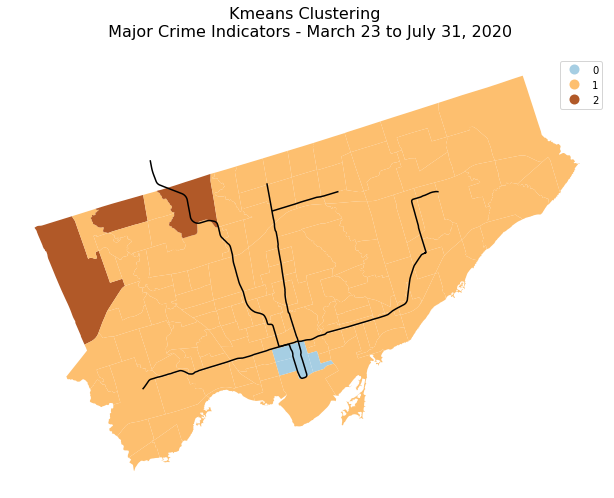

In [43]:
LD1mapping_clusters(kmeans_method.labels_);

path = os.path.join('','img')
fn = 'LD-kmeans-cluster-k3.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


Done.


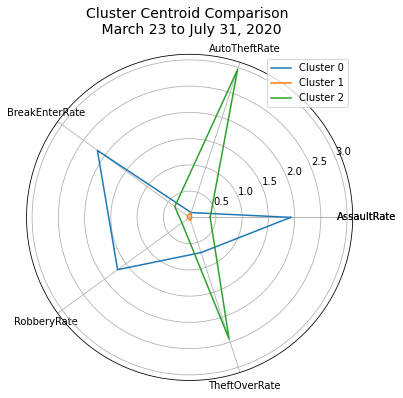

In [44]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=LD1normed.columns)
LD1radar_plot_cluster_centroids(df_cluster_centroid);

path = os.path.join('','img')
fn = 'LD-kmeans-centroid-comp-k3.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

In [45]:
# recall the key neighbourhoods from our earlier observations:

    # During the first lockdown
        # Moss Park had the highest rates of overall crime, assault, and robbery
        # Humber Summit had the highest rates of auto theft and theft over
        # Kensington-Chinatown had the highest rate of break and enter
        
    # During the same period a year before the first lockdown:
        # Moss Park had the highest rates of overall crime and robbery
        # Bay Street Corridor had the highest rates of assault and theft over
        # West Humber-Clairville had the highest rate of auto theft
        # Kensington-Chinatown had the highest rate of break and enter

# let's look at what LD k-means clusters our key neighbbourhoods belong to when k = 3
print(f"Moss Park is located in cluster {LD1['cluster_nm'].loc[(LD1['Neighbourhood']=='Moss Park')]}.")
print(f"Humber Summit is located in cluster {LD1['cluster_nm'].loc[(LD1['Neighbourhood']=='Humber Summit')]}.")
print(f"Bay Street Corridor is located in cluster {LD1['cluster_nm'].loc[(LD1['Neighbourhood']=='Bay Street Corridor')]}.")
print(f"West Humber-Clairville is located in cluster {LD1['cluster_nm'].loc[(LD1['Neighbourhood']=='West Humber-Clairville')]}.")
print(f"Kensington-Chinatown is located in cluster {LD1['cluster_nm'].loc[(LD1['Neighbourhood']=='Kensington-Chinatown')]}.")

Moss Park is located in cluster 72    0
Name: cluster_nm, dtype: int32.
Humber Summit is located in cluster 20    2
Name: cluster_nm, dtype: int32.
Bay Street Corridor is located in cluster 75    0
Name: cluster_nm, dtype: int32.
West Humber-Clairville is located in cluster 0    2
Name: cluster_nm, dtype: int32.
Kensington-Chinatown is located in cluster 77    0
Name: cluster_nm, dtype: int32.


In [46]:
# recall the average crime rates from our earlier observations:

    # During the first lockdown
        # average assault rate was 214.9
        # average auto theft rate was 72.23
        # average break enter rate was 84.53
        # average robbery rate was 26.4
        # average theft over rate was 13.12
        
    # During the same period a year before the first lockdown:
        # average assault rate was 272.83
        # average auto theft rate was 68.41
        # average break enter rate was 111.67
        # average robbery rate was 43.09
        # average theft over rate was 17.71

# let's look at the average crime rate of our LD1 k-means clusters for each MCI when k = 3
LD1.groupby('cluster_nm')['AssaultRate', 'AutoTheftRate', 'BreakEnterRate', 'RobberyRate', 'TheftOverRate'].mean().round(decimals = 2)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
cluster_nm,,,,,
0,796.58,66.14,394.15,110.59,28.16
1,190.83,65.86,72.06,23.12,11.17
2,304.63,362.86,116.94,30.47,73.77


In [47]:
# let's look at the average normalized crime rate of our LD1 k-means clusters for each MCI when k = 3
LD1n = pd.merge(LD1, LD1normed, on=['Hood_ID'])
LD1n.groupby('cluster_nm')['AssaultRate_y', 'AutoTheftRate_y', 'BreakEnterRate_y', 'RobberyRate_y', 'TheftOverRate_y'].mean().round(decimals = 2)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,AssaultRate_y,AutoTheftRate_y,BreakEnterRate_y,RobberyRate_y,TheftOverRate_y
cluster_nm,,,,,
0,1.93,0.10,2.17,1.70,0.71
1,0.04,0.09,0.05,0.04,0.06
2,0.39,2.96,0.35,0.18,2.43


##### Elbow method

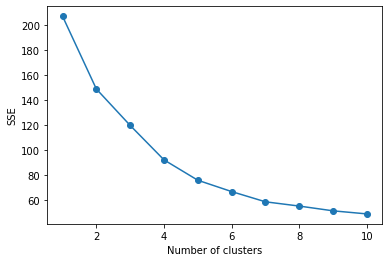

In [48]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(LD1normed)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later


Done.


<Figure size 576x432 with 0 Axes>

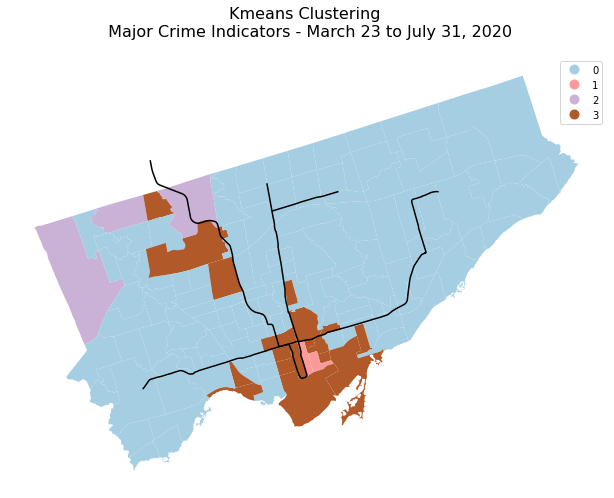

In [49]:
# Elbow method suggest 4 could also be optimal, let's test
k_cluster = 4
random_seed = 123
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(LD1normed)

# plotting
LD1mapping_clusters(kmeans_method.labels_);

path = os.path.join('','img')
fn = 'LD-kmeans-cluster-k4.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


Done.


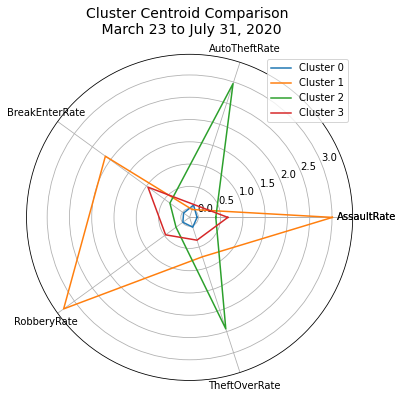

In [50]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=LD1normed.columns)
LD1radar_plot_cluster_centroids(df_cluster_centroid)

path = os.path.join('','img')
fn = 'LD-kmeans-centroid-comp-k4.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

In [51]:
# recall the key neighbourhoods from our earlier observations:

    # During the first lockdown
        # Moss Park had the highest rates of overall crime, assault, and robbery
        # Humber Summit had the highest rates of auto theft and theft over
        # Kensington-Chinatown had the highest rate of break and enter
        
    # During the same period a year before the first lockdown:
        # Moss Park had the highest rates of overall crime and robbery
        # Bay Street Corridor had the highest rates of assault and theft over
        # West Humber-Clairville had the highest rate of auto theft
        # Kensington-Chinatown had the highest rate of break and enter

# let's look at what LD1 k-means clusters our key neighbbourhoods belong to when k = 4
print(f"Moss Park is located in cluster {LD1['cluster_nm'].loc[(LD1['Neighbourhood']=='Moss Park')]}.")
print(f"Humber Summit is located in cluster {LD1['cluster_nm'].loc[(LD1['Neighbourhood']=='Humber Summit')]}.")
print(f"Bay Street Corridor is located in cluster {LD1['cluster_nm'].loc[(LD1['Neighbourhood']=='Bay Street Corridor')]}.")
print(f"West Humber-Clairville is located in cluster {LD1['cluster_nm'].loc[(LD1['Neighbourhood']=='West Humber-Clairville')]}.")
print(f"Kensington-Chinatown is located in cluster {LD1['cluster_nm'].loc[(LD1['Neighbourhood']=='Kensington-Chinatown')]}.")

Moss Park is located in cluster 72    1
Name: cluster_nm, dtype: int32.
Humber Summit is located in cluster 20    2
Name: cluster_nm, dtype: int32.
Bay Street Corridor is located in cluster 75    3
Name: cluster_nm, dtype: int32.
West Humber-Clairville is located in cluster 0    2
Name: cluster_nm, dtype: int32.
Kensington-Chinatown is located in cluster 77    3
Name: cluster_nm, dtype: int32.


In [52]:
# recall the average crime rates from our earlier observations:

    # During the first lockdown
        # average crime rate was 411.18
        # average assault rate was 214.9
        # average auto theft rate was 72.23
        # average break enter rate was 84.53
        # average robbery rate was 26.4
        # average theft over rate was 13.12
        
    # During the same period a year before the first lockdown:
        # average crime rate was 513.72
        # average assault rate was 272.83
        # average auto theft rate was 68.41
        # average break enter rate was 111.67
        # average robbery rate was 43.09
        # average theft over rate was 17.71

# let's look at the average crime rate of our LD1 k-means clusters for each MCI when k = 4
LD1.groupby('cluster_nm')['AssaultRate', 'AutoTheftRate', 'BreakEnterRate', 'RobberyRate', 'TheftOverRate'].mean().round(decimals = 2)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
cluster_nm,,,,,
0,169.56,65.83,59.23,20.42,10.46
1,1143.98,55.06,389.50,195.30,28.90
2,304.63,362.86,116.94,30.47,73.77
3,391.48,67.34,209.69,45.78,18.55


In [53]:
# let's look at the average normalized crime rate of our LD1 k-means clusters for each MCI when k = 4
LD1n = pd.merge(LD1, LD1normed, on=['Hood_ID'])
LD1n.groupby('cluster_nm')['AssaultRate_y', 'AutoTheftRate_y', 'BreakEnterRate_y', 'RobberyRate_y', 'TheftOverRate_y'].mean().round(decimals = 2)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,AssaultRate_y,AutoTheftRate_y,BreakEnterRate_y,RobberyRate_y,TheftOverRate_y
cluster_nm,,,,,
0,-0.03,0.09,-0.03,-0.01,0.03
1,3.01,-0.01,2.14,3.30,0.73
2,0.39,2.96,0.35,0.18,2.43
3,0.66,0.11,0.96,0.47,0.34


#### One Year Previous - March 23 to July 31, 2019

In [54]:
# we will again try k=3 to start

k_cluster = 3
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(OYPnormed)

KMeans(n_clusters=3, random_state=1)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later
  # Remove the CWD from sys.path while we load stuff.


Done.


<Figure size 576x432 with 0 Axes>

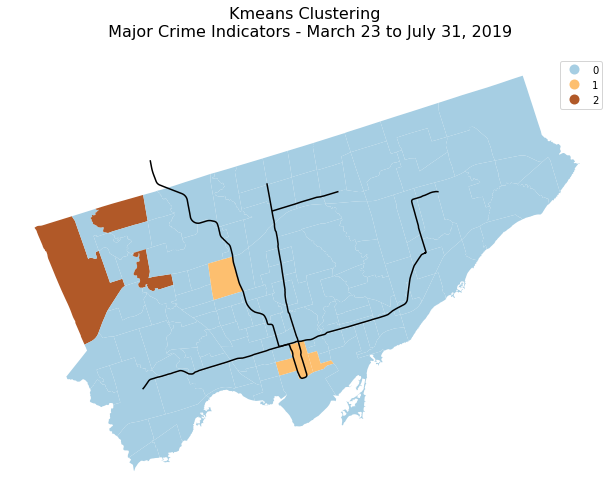

In [55]:
OYPmapping_clusters(kmeans_method.labels_);

path = os.path.join('','img')
fn = 'OYP-kmeans-cluster-k3.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


Done.


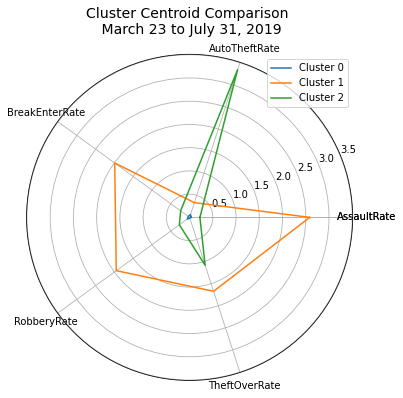

In [56]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=OYPnormed.columns)
OYPradar_plot_cluster_centroids(df_cluster_centroid)

path = os.path.join('','img')
fn = 'OYP-kmeans-centroid-comp-k3.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

In [57]:
# recall the key neighbourhoods from our earlier observations:

    # During the first lockdown
        # Moss Park had the highest rates of overall crime, assault, and robbery
        # Humber Summit had the highest rates of auto theft and theft over
        # Kensington-Chinatown had the highest rate of break and enter
        
    # During the same period a year before the first lockdown:
        # Moss Park had the highest rates of overall crime and robbery
        # Bay Street Corridor had the highest rates of assault and theft over
        # West Humber-Clairville had the highest rate of auto theft
        # Kensington-Chinatown had the highest rate of break and enter

# let's look at what OYP k-means clusters our key neighbbourhoods belong to when k = 3
print(f"Moss Park is located in cluster {OYP['cluster_nm'].loc[(OYP['Neighbourhood']=='Moss Park')]}.")
print(f"Humber Summit is located in cluster {OYP['cluster_nm'].loc[(OYP['Neighbourhood']=='Humber Summit')]}.")
print(f"Bay Street Corridor is located in cluster {OYP['cluster_nm'].loc[(OYP['Neighbourhood']=='Bay Street Corridor')]}.")
print(f"West Humber-Clairville is located in cluster {OYP['cluster_nm'].loc[(OYP['Neighbourhood']=='West Humber-Clairville')]}.")
print(f"Kensington-Chinatown is located in cluster {OYP['cluster_nm'].loc[(OYP['Neighbourhood']=='Kensington-Chinatown')]}.")

Moss Park is located in cluster 72    1
Name: cluster_nm, dtype: int32.
Humber Summit is located in cluster 20    2
Name: cluster_nm, dtype: int32.
Bay Street Corridor is located in cluster 75    1
Name: cluster_nm, dtype: int32.
West Humber-Clairville is located in cluster 0    2
Name: cluster_nm, dtype: int32.
Kensington-Chinatown is located in cluster 77    1
Name: cluster_nm, dtype: int32.


In [58]:
# recall the average crime rates from our earlier observations:

    # During the first lockdown
        # average crime rate was 411.18
        # average assault rate was 214.9
        # average auto theft rate was 72.23
        # average break enter rate was 84.53
        # average robbery rate was 26.4
        # average theft over rate was 13.12
        
    # During the same period a year before the first lockdown:
        # average crime rate was 513.72
        # average assault rate was 272.83
        # average auto theft rate was 68.41
        # average break enter rate was 111.67
        # average robbery rate was 43.09
        # average theft over rate was 17.71

# let's look at the average crime rate of our OYP k-means clusters for each MCI when k = 3
OYP.groupby('cluster_nm')['AssaultRate', 'AutoTheftRate', 'BreakEnterRate', 'RobberyRate', 'TheftOverRate'].mean().round(decimals = 2)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
cluster_nm,,,,,
0,242.42,59.59,100.33,37.89,14.93
1,1057.96,89.22,399.31,174.46,71.04
2,302.71,421.47,131.24,53.18,51.13


In [59]:
# let's look at the average normalized crime rate of our OYP k-means clusters for each MCI when k = 3
OYPn = pd.merge(OYP, OYPnormed, on=['Hood_ID'])
OYPn.groupby('cluster_nm')['AssaultRate_y', 'AutoTheftRate_y', 'BreakEnterRate_y', 'RobberyRate_y', 'TheftOverRate_y'].mean().round(decimals = 2)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,AssaultRate_y,AutoTheftRate_y,BreakEnterRate_y,RobberyRate_y,TheftOverRate_y
cluster_nm,,,,,
0,0.03,0.07,0.04,0.06,0.02
1,2.59,0.33,1.99,1.95,1.67
2,0.22,3.34,0.24,0.27,1.08


##### Elbow method

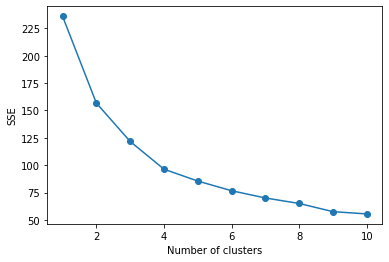

In [60]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(OYPnormed)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later


Done.


<Figure size 576x432 with 0 Axes>

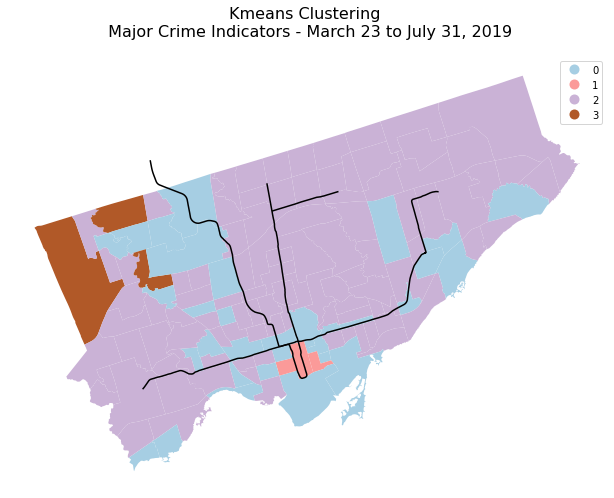

In [61]:
# elbow method suggests 4 could also be optimal, let's test
k_cluster = 4
random_seed = 123
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(OYPnormed)

# plotting
OYPmapping_clusters(kmeans_method.labels_);

path = os.path.join('','img')
fn = 'OYP-kmeans-cluster-k4.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


Done.


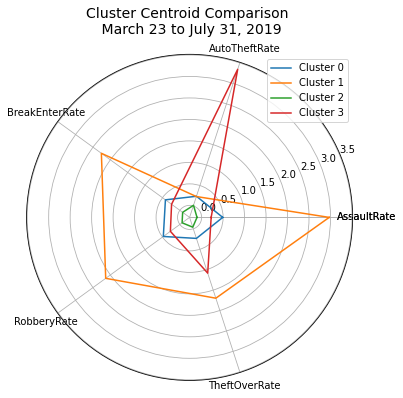

In [62]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=OYPnormed.columns)
OYPradar_plot_cluster_centroids(df_cluster_centroid)

path = os.path.join('','img')
fn = 'OYP-kmeans-centroid-comp-k4.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

In [63]:
# recall the key neighbourhoods from our earlier observations:

    # During the first lockdown
        # Moss Park had the highest rates of overall crime, assault, and robbery
        # Humber Summit had the highest rates of auto theft and theft over
        # Kensington-Chinatown had the highest rate of break and enter
        
    # During the same period a year before the first lockdown:
        # Moss Park had the highest rates of overall crime and robbery
        # Bay Street Corridor had the highest rates of assault and theft over
        # West Humber-Clairville had the highest rate of auto theft
        # Kensington-Chinatown had the highest rate of break and enter

# let's look at what OYP k-means clusters our key neighbbourhoods belong to when k = 4
print(f"Moss Park is located in cluster {OYP['cluster_nm'].loc[(OYP['Neighbourhood']=='Moss Park')]}.")
print(f"Humber Summit is located in cluster {OYP['cluster_nm'].loc[(OYP['Neighbourhood']=='Humber Summit')]}.")
print(f"Bay Street Corridor is located in cluster {OYP['cluster_nm'].loc[(OYP['Neighbourhood']=='Bay Street Corridor')]}.")
print(f"West Humber-Clairville is located in cluster {OYP['cluster_nm'].loc[(OYP['Neighbourhood']=='West Humber-Clairville')]}.")
print(f"Kensington-Chinatown is located in cluster {OYP['cluster_nm'].loc[(OYP['Neighbourhood']=='Kensington-Chinatown')]}.")

Moss Park is located in cluster 72    1
Name: cluster_nm, dtype: int32.
Humber Summit is located in cluster 20    3
Name: cluster_nm, dtype: int32.
Bay Street Corridor is located in cluster 75    1
Name: cluster_nm, dtype: int32.
West Humber-Clairville is located in cluster 0    3
Name: cluster_nm, dtype: int32.
Kensington-Chinatown is located in cluster 77    1
Name: cluster_nm, dtype: int32.


In [64]:
# recall the average crime rates from our earlier observations:

    # During the first lockdown
        # average crime rate was 411.18
        # average assault rate was 214.9
        # average auto theft rate was 72.23
        # average break enter rate was 84.53
        # average robbery rate was 26.4
        # average theft over rate was 13.12
        
    # During the same period a year before the first lockdown:
        # average crime rate was 513.72
        # average assault rate was 272.83
        # average auto theft rate was 68.41
        # average break enter rate was 111.67
        # average robbery rate was 43.09
        # average theft over rate was 17.71

# let's look at the average crime rate of our OYP k-means clusters for each MCI when k = 4
OYP.groupby('cluster_nm')['AssaultRate', 'AutoTheftRate', 'BreakEnterRate', 'RobberyRate', 'TheftOverRate'].mean().round(decimals = 2)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
cluster_nm,,,,,
0,388.83,78.48,158.27,67.89,22.33
1,1180.60,77.75,440.04,187.67,71.92
2,197.35,54.11,82.57,28.82,13.02
3,302.71,421.47,131.24,53.18,51.13


In [65]:
# let's look at the average normalized crime rate of our OYP k-means clusters for each MCI when k = 4
OYPn = pd.merge(OYP, OYPnormed, on=['Hood_ID'])
OYPn.groupby('cluster_nm')['AssaultRate_y', 'AutoTheftRate_y', 'BreakEnterRate_y', 'RobberyRate_y', 'TheftOverRate_y'].mean().round(decimals = 2)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,AssaultRate_y,AutoTheftRate_y,BreakEnterRate_y,RobberyRate_y,TheftOverRate_y
cluster_nm,,,,,
0,0.49,0.24,0.41,0.48,0.23
1,2.97,0.23,2.26,2.13,1.70
2,-0.11,0.02,-0.08,-0.06,-0.04
3,0.22,3.34,0.24,0.27,1.08


## 2.3. Max-P Regionalisation

#### First Lockdown - March 23 to July 31, 2020

In [66]:
plt.rcParams["figure.figsize"] = [12, 8]
warnings.filterwarnings("ignore")

RANDOM_SEED = 123456

In [67]:
attrs_name = LD1normed.columns.values.tolist()
attrs_name

['AssaultRate',
 'AutoTheftRate',
 'BreakEnterRate',
 'RobberyRate',
 'TheftOverRate']

In [68]:
w = libpysal.weights.Queen.from_dataframe(nbs)

In [69]:
threshold = 0.2 * LD1normed.shape[0]
print(threshold)
LD1normed_copy = LD1normed.copy()
LD1normed_copy["count"] = 1
threshold_name = "count"

28.0


In [70]:
%%time
np.random.seed(RANDOM_SEED)
model = MaxP(LD1normed_copy, w, attrs_name, threshold_name, threshold, top_n=3)
model.solve()

CPU times: user 351 ms, sys: 0 ns, total: 351 ms
Wall time: 350 ms


Done.


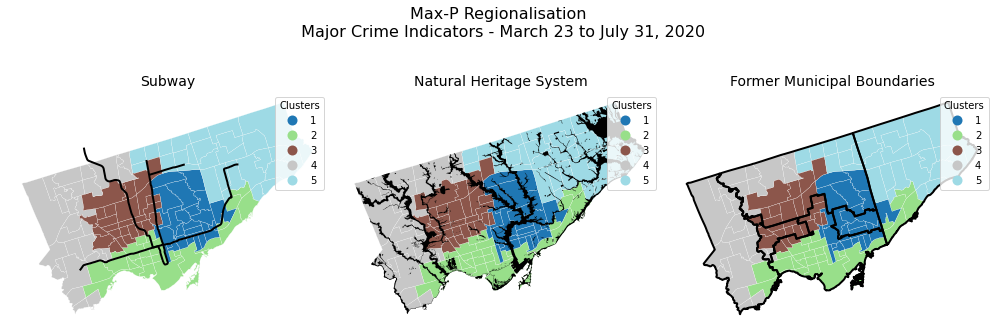

In [71]:
# max p plots combined 

fig = plt.figure()
fig.set_size_inches(14, 5)
fig.suptitle(f"Max-P Regionalisation \n Major Crime Indicators - March 23 to July 31, 2020", ha='center', size=16, y=1)

ax = plt.subplot(1, 3, 1)
nbs['cluster_max_p'] = model.labels_
nbs.plot(ax=ax, column='cluster_max_p', categorical=True, legend=True, cmap='tab20', edgecolor="w", linewidth=0.2, zorder=1, figsize=(6,4))
subway.plot(ax=ax, color='black', linewidth=2, zorder=2, figsize=(6,4))
plt.title('Subway', fontsize=14, color='black')
plt.axis('off')
ax.get_legend().set_title("Clusters")

ax = plt.subplot(1, 3, 2)
nbs['cluster_max_p'] = model.labels_
nbs.plot(ax=ax, column='cluster_max_p', categorical=True, legend=True, cmap='tab20', edgecolor="w", linewidth=0.2, zorder=1, figsize=(6,4))
nhs.plot(ax=ax, color='black', zorder=2, figsize=(6,4))
plt.title('Natural Heritage System', fontsize=14, color='black')
plt.axis('off')
ax.get_legend().set_title("Clusters")

ax = plt.subplot(1, 3, 3)
nbs['cluster_max_p'] = model.labels_
nbs.plot(ax=ax, column='cluster_max_p', categorical=True, legend=True, cmap='tab20', edgecolor="w", linewidth=0.2, zorder=1, figsize=(6,4))
formercities.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2, zorder=2, figsize=(6,4))
plt.title('Former Municipal Boundaries', fontsize=14, color='black')
plt.axis('off')
ax.get_legend().set_title("Clusters")

fig.tight_layout()
fig.show()

path = os.path.join('','img')
fn = 'LD-maxp-cluster.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

In [72]:
# recall the key neighbourhoods from our earlier observations:

    # During the first lockdown
        # Moss Park had the highest rates of overall crime, assault, and robbery
        # Humber Summit had the highest rates of auto theft and theft over
        # Kensington-Chinatown had the highest rate of break and enter
        
    # During the same period a year before the first lockdown:
        # Moss Park had the highest rates of overall crime and robbery
        # Bay Street Corridor had the highest rates of assault and theft over
        # West Humber-Clairville had the highest rate of auto theft
        # Kensington-Chinatown had the highest rate of break and enter

# let's look at what LD1 max p clusters our key neighbbourhoods belong to
print(f"Moss Park is located in cluster {nbs['cluster_max_p'].loc[(nbs['Neighbourhood']=='Moss Park')]}.")
print(f"Humber Summit is located in cluster {nbs['cluster_max_p'].loc[(nbs['Neighbourhood']=='Humber Summit')]}.")
print(f"Bay Street Corridor is located in cluster {nbs['cluster_max_p'].loc[(nbs['Neighbourhood']=='Bay Street Corridor')]}.")
print(f"West Humber-Clairville is located in cluster {nbs['cluster_max_p'].loc[(nbs['Neighbourhood']=='West Humber-Clairville')]}.")
print(f"Kensington-Chinatown is located in cluster {nbs['cluster_max_p'].loc[(nbs['Neighbourhood']=='Kensington-Chinatown')]}.")

Moss Park is located in cluster 19    2
Name: cluster_max_p, dtype: int64.
Humber Summit is located in cluster 114    4
Name: cluster_max_p, dtype: int64.
Bay Street Corridor is located in cluster 94    2
Name: cluster_max_p, dtype: int64.
West Humber-Clairville is located in cluster 41    4
Name: cluster_max_p, dtype: int64.
Kensington-Chinatown is located in cluster 5    2
Name: cluster_max_p, dtype: int64.


In [73]:
# recall the average crime rates from our earlier observations:

    # During the first lockdown
        # average crime rate was 411.18
        # average assault rate was 214.9
        # average auto theft rate was 72.23
        # average break enter rate was 84.53
        # average robbery rate was 26.4
        # average theft over rate was 13.12
        
    # During the same period a year before the first lockdown:
        # average crime rate was 513.72
        # average assault rate was 272.83
        # average auto theft rate was 68.41
        # average break enter rate was 111.67
        # average robbery rate was 43.09
        # average theft over rate was 17.71

# let's look at the average crime rate of our LD1 max p clusters for each MCI
LD1 = pd.merge(LD1, nbs, on=['Hood_ID'])
LD1.groupby('cluster_max_p')['AssaultRate', 'AutoTheftRate', 'BreakEnterRate', 'RobberyRate', 'TheftOverRate'].mean().round(decimals = 2)

,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
cluster_max_p,,,,,
1,219.51,34.17,97.81,28.91,8.63
2,332.05,48.71,154.14,36.84,16.65
3,190.51,85.20,79.75,22.02,12.67
4,173.92,131.62,55.96,23.85,19.27
5,158.54,61.46,34.99,20.37,8.37


In [74]:
# let's look at the average normalized crime rate of our LD1 max p clusters for each MCI
LD1n = pd.merge(LD1, LD1normed, on=['Hood_ID'])
LD1n.groupby('cluster_max_p')['AssaultRate_y', 'AutoTheftRate_y', 'BreakEnterRate_y', 'RobberyRate_y', 'TheftOverRate_y'].mean().round(decimals = 2)

,AssaultRate_y,AutoTheftRate_y,BreakEnterRate_y,RobberyRate_y,TheftOverRate_y
cluster_max_p,,,,,
1,0.13,-0.21,0.22,0.15,-0.03
2,0.48,-0.07,0.59,0.30,0.27
3,0.04,0.28,0.10,0.02,0.12
4,-0.02,0.73,-0.05,0.05,0.37
5,-0.06,0.05,-0.19,-0.01,-0.04


#### One Year Previous - March 23 to July 31, 2019

In [75]:
plt.rcParams["figure.figsize"] = [12, 8]
warnings.filterwarnings("ignore")

RANDOM_SEED = 123456

In [76]:
attrs_name = OYPnormed.columns.values.tolist()
attrs_name

['AssaultRate',
 'AutoTheftRate',
 'BreakEnterRate',
 'RobberyRate',
 'TheftOverRate']

In [77]:
w = libpysal.weights.Queen.from_dataframe(nbs)

In [78]:
threshold = 0.2 * OYPnormed.shape[0]
print(threshold)
OYPnormed_copy = OYPnormed.copy()
OYPnormed_copy["count"] = 1
threshold_name = "count"

28.0


In [79]:
%%time
np.random.seed(RANDOM_SEED)
model = MaxP(OYPnormed_copy, w, attrs_name, threshold_name, threshold, top_n=3)
model.solve()

CPU times: user 361 ms, sys: 9.85 ms, total: 371 ms
Wall time: 370 ms


Done.


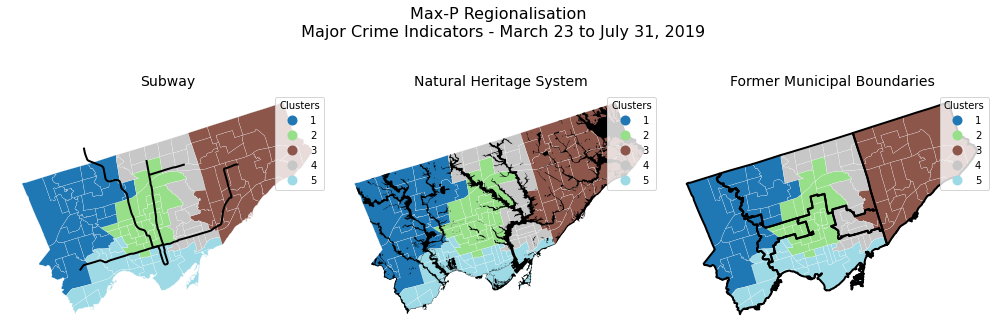

In [80]:
# max p plots combined 

fig = plt.figure()
fig.set_size_inches(14, 5)
fig.suptitle(f"Max-P Regionalisation \n Major Crime Indicators - March 23 to July 31, 2019", ha='center', size=16, y=1)

ax = plt.subplot(1, 3, 1)
nbs['cluster_max_p'] = model.labels_
nbs.plot(ax=ax, column='cluster_max_p', categorical=True, legend=True, cmap='tab20', edgecolor="w", linewidth=0.2, zorder=1, figsize=(6,4))
subway.plot(ax=ax, color='black', linewidth=2, zorder=2, figsize=(6,4))
plt.title('Subway', fontsize=14, color='black')
plt.axis('off')
ax.get_legend().set_title("Clusters")

ax = plt.subplot(1, 3, 2)
nbs['cluster_max_p'] = model.labels_
nbs.plot(ax=ax, column='cluster_max_p', categorical=True, legend=True, cmap='tab20', edgecolor="w", linewidth=0.2, zorder=1, figsize=(6,4))
nhs.plot(ax=ax, color='black', zorder=2, figsize=(6,4))
plt.title('Natural Heritage System', fontsize=14, color='black')
plt.axis('off')
ax.get_legend().set_title("Clusters")

ax = plt.subplot(1, 3, 3)
nbs['cluster_max_p'] = model.labels_
nbs.plot(ax=ax, column='cluster_max_p', categorical=True, legend=True, cmap='tab20', edgecolor="w", linewidth=0.2, zorder=1, figsize=(6,4))
formercities.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2, zorder=2, figsize=(6,4))
plt.title('Former Municipal Boundaries', fontsize=14, color='black')
plt.axis('off')
ax.get_legend().set_title("Clusters")

fig.tight_layout()
fig.show()

path = os.path.join('','img')
fn = 'OYP-maxp-cluster.png'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
plt.savefig(os.path.join(path,fn), dpi=150, index=False)
print("Done.")

In [81]:
# recall the key neighbourhoods from our earlier observations:

    # During the first lockdown
        # Moss Park had the highest rates of overall crime, assault, and robbery
        # Humber Summit had the highest rates of auto theft and theft over
        # Kensington-Chinatown had the highest rate of break and enter
        
    # During the same period a year before the first lockdown:
        # Moss Park had the highest rates of overall crime and robbery
        # Bay Street Corridor had the highest rates of assault and theft over
        # West Humber-Clairville had the highest rate of auto theft
        # Kensington-Chinatown had the highest rate of break and enter

# let's look at what OTP max p clusters our key neighbbourhoods belong to
print(f"Moss Park is located in cluster {nbs['cluster_max_p'].loc[(nbs['Neighbourhood']=='Moss Park')]}.")
print(f"Humber Summit is located in cluster {nbs['cluster_max_p'].loc[(nbs['Neighbourhood']=='Humber Summit')]}.")
print(f"Bay Street Corridor is located in cluster {nbs['cluster_max_p'].loc[(nbs['Neighbourhood']=='Bay Street Corridor')]}.")
print(f"West Humber-Clairville is located in cluster {nbs['cluster_max_p'].loc[(nbs['Neighbourhood']=='West Humber-Clairville')]}.")
print(f"Kensington-Chinatown is located in cluster {nbs['cluster_max_p'].loc[(nbs['Neighbourhood']=='Kensington-Chinatown')]}.")

Moss Park is located in cluster 19    5
Name: cluster_max_p, dtype: int64.
Humber Summit is located in cluster 114    1
Name: cluster_max_p, dtype: int64.
Bay Street Corridor is located in cluster 94    5
Name: cluster_max_p, dtype: int64.
West Humber-Clairville is located in cluster 41    1
Name: cluster_max_p, dtype: int64.
Kensington-Chinatown is located in cluster 5    5
Name: cluster_max_p, dtype: int64.


In [82]:
# recall the average crime rates from our earlier observations:

    # During the first lockdown
        # average crime rate was 411.18
        # average assault rate was 214.9
        # average auto theft rate was 72.23
        # average break enter rate was 84.53
        # average robbery rate was 26.4
        # average theft over rate was 13.12
        
    # During the same period a year before the first lockdown:
        # average crime rate was 513.72
        # average assault rate was 272.83
        # average auto theft rate was 68.41
        # average break enter rate was 111.67
        # average robbery rate was 43.09
        # average theft over rate was 17.71

# let's look at the average crime rate of our OYP max p clusters for each MCI
OYP = pd.merge(OYP, nbs, on=['Hood_ID'])
OYP.groupby('cluster_max_p')['AssaultRate', 'AutoTheftRate', 'BreakEnterRate', 'RobberyRate', 'TheftOverRate'].mean().round(decimals = 2)

,AssaultRate,AutoTheftRate,BreakEnterRate,RobberyRate,TheftOverRate
cluster_max_p,,,,,
1,246.50,136.52,76.47,42.98,16.92
2,211.35,51.27,122.11,36.50,18.54
3,272.61,48.07,95.23,40.56,10.54
4,220.94,46.25,79.75,26.90,16.51
5,412.77,59.91,184.80,68.52,26.06


In [83]:
# let's look at the average normalized crime rate of our LD1 max p clusters for each MCI
OYPn = pd.merge(OYP, OYPnormed, on=['Hood_ID'])
OYPn.groupby('cluster_max_p')['AssaultRate_y', 'AutoTheftRate_y', 'BreakEnterRate_y', 'RobberyRate_y', 'TheftOverRate_y'].mean().round(decimals = 2)

,AssaultRate_y,AutoTheftRate_y,BreakEnterRate_y,RobberyRate_y,TheftOverRate_y
cluster_max_p,,,,,
1,0.05,0.76,-0.12,0.13,0.07
2,-0.06,-0.01,0.18,0.04,0.12
3,0.13,-0.04,0.00,0.10,-0.11
4,-0.03,-0.06,-0.10,-0.09,0.06
5,0.57,0.07,0.59,0.48,0.34


## 3. Credits!

### Data

- ‘Open Data Dataset’. (no date b). Available at: https://open.toronto.ca/dataset/former-municipality-boundaries/ (Accessed: 1 May 2022).
- ‘Open Data Dataset’. (no date d). Available at: https://open.toronto.ca/dataset/natural-heritage-system/ (Accessed: 1 May 2022).
- ‘Open Data Dataset’. (no date f). Available at: https://open.toronto.ca/dataset/ttc-subway-shapefiles/ (Accessed: 1 May 2022).

### Clustering

- Duque, J. C., Anselin, L. and Rey, S. J. (2012). ‘THE MAX-P-REGIONS PROBLEM*’. Journal of Regional Science, 52 (3), pp. 397–419. doi: 10.1111/j.1467-9787.2011.00743.x.
- ‘GeoPandas | How to Visualise data in Maps Using GeoPandas’. (2021). Analytics Vidhya, 16 September. Available at: https://www.analyticsvidhya.com/blog/2021/09/how-to-visualise-data-in-maps-using-geopandas/ (Accessed: 1 May 2022).
- K-Means Clustering using Python. Previously I have written about one… | by rindangchi | Nerd For Tech | Medium. (no date). Available at: https://medium.com/nerd-for-tech/k-means-clustering-using-python-2150769bd0b9 (Accessed: 1 May 2022).
- Lewis, R. (2021). Plotting Maps with GeoPandas. Medium. Available at: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73 (Accessed: 1 May 2022).
- Li, S. (2018). Exploring, Clustering and Mapping Toronto’s Crimes. Medium. Available at: https://towardsdatascience.com/exploring-clustering-and-mapping-torontos-crimes-96336efe490f (Accessed: 1 May 2022).
- Mapping and Plotting Tools — GeoPandas 0.10.2+0.g04d377f.dirty documentation. (no date). Available at: https://geopandas.org/en/stable/docs/user_guide/mapping.html (Accessed: 1 May 2022).
- ‘Pandas Select DataFrame Rows Between Two Dates’. (2021). Spark by {Examples}, 26 November. Available at: https://sparkbyexamples.com/pandas/pandas-select-dataframe-rows-between-two-dates/ (Accessed: 1 May 2022).
- Penumudy, T. (2021). ‘Crime Data Pattern Analysis and Visualization using K-means Clustering’. Analytics Vidhya, 29 January. Available at: https://medium.com/analytics-vidhya/crime-data-pattern-analysis-and-visualization-using-k-means-clustering-ceeb963a2b47 (Accessed: 1 May 2022).
- Radečić, D. (2022). How to Make Stunning Radar Charts with Python — Implemented in Matplotlib and Plotly. Medium. Available at: https://towardsdatascience.com/how-to-make-stunning-radar-charts-with-python-implemented-in-matplotlib-and-plotly-91e21801d8ca (Accessed: 1 May 2022).
- Real Python. (no date). K-Means Clustering in Python: A Practical Guide. Available at: https://realpython.com/k-means-clustering-python/ (Accessed: 1 May 2022).
- Select Pandas dataframe rows between two dates | Data Interview Questions. (no date). Available at: https://www.interviewqs.com/ddi-code-snippets/select-pandas-dataframe-rows-between-two-dates (Accessed: 1 May 2022).
- The Clustering Algorithm with Geolocation data | by Tri Basuki Kurniawan | TheLorry Data, Tech & Product | Medium. (no date). Available at: https://medium.com/thelorry-product-tech-data/the-clustering-algorithm-with-geolocation-data-d6dd07ed36a (Accessed: 1 May 2022).
- US Crime Rate - K-means Clustering. (no date). Available at: https://kaggle.com/akshayreddykotha/us-crime-rate-k-means-clustering (Accessed: 1 May 2022).
- Wei, R., Rey, S. and Knaap, E. (2021). ‘Efficient regionalization for spatially explicit neighborhood delineation’. International Journal of Geographical Information Science, 35 (1), pp. 135–151. doi: 10.1080/13658816.2020.1759806.